In [244]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from asset_data_module import read_close_prices_all_merged
from features import make_feature_windows

In [245]:
markets = ['dow30']
# markets = ['commodities']
# start_date, end_date = "2022-01-01", "2025-11-28"
start_date, end_date = "2022-06-01", "2025-11-28"

_, close_df = read_close_prices_all_merged(markets, after_date=start_date)
close_df = close_df.loc[:end_date]

rolling = make_feature_windows(
    close_prices=close_df,
    lookback=50,
    horizon=1,
    days_per_week=5
)
close_df.shape, len(rolling)

((878, 30), 125)

In [246]:
def rolling_to_period_returns_df(rolling, y_key="y_ret", date_key="t1"):
    rows = []
    for i, w in enumerate(rolling):
        y = w[y_key]
        if not isinstance(y, pd.Series):
            y = pd.Series(y)
        dt = w.get(date_key, i)
        s = y.copy()
        s.name = dt
        rows.append(s)
    R = pd.DataFrame(rows)
    R.index.name = "t"
    return R  # shape: (num_windows, num_assets)

In [247]:
R = rolling_to_period_returns_df(rolling, y_key="y_ret", date_key="t1")
R.shape

(125, 30)

In [248]:
# def arma_forecast_one(series, p=1, q=1):
#     """series: 1D array-like of past returns."""
#     series = pd.Series(series).dropna()
#     if len(series) < max(p, q) + 5:
#         return float(series.mean()) if len(series) else 0.0

#     try:
#         model = ARIMA(series, order=(p, 0, q), trend="c",
#                       enforce_stationarity=False, enforce_invertibility=False)
#         fit = model.fit()
#         return float(fit.forecast(steps=1).iloc[0])
#     except Exception:
#         # robust fallback
#         return float(series.mean())
    
def arma_forecast_one(series, p=1, q=0):
    s = pd.Series(series).dropna()
    if len(s) < max(p, q) + 10:
        return float(s.mean()) if len(s) else 0.0

    try:
        model = ARIMA(
            s,
            order=(p, 0, q),
            trend="n",  # no intercept for returns
            enforce_stationarity=False,
            enforce_invertibility=False,
        )
        fit = model.fit(method_kwargs={"maxiter": 200})
        # if optimizer didn't converge, treat as fail
        if hasattr(fit, "mle_retvals") and not fit.mle_retvals.get("converged", True):
            return float(s.mean())
        return float(fit.forecast(steps=1).iloc[0])
    except Exception:
        return float(s.mean())

In [249]:
R.head(3)

,dow30:AAPL,dow30:AMGN,dow30:AXP,dow30:BA,dow30:CAT,dow30:CRM,dow30:CSCO,dow30:CVX,dow30:DIS,dow30:DOW,...,dow30:MSFT,dow30:NKE,dow30:PFE,dow30:PG,dow30:RTX,dow30:TRV,dow30:UNH,dow30:V,dow30:VZ,dow30:WMT
t,,,,,,,,,,,,,,,,,,,,,
2023-06-06,0.010997,0.002580,0.080314,0.007700,0.096877,-0.048287,0.002815,0.033749,0.046644,0.075206,...,0.015980,0.012083,0.009163,0.013868,0.055928,0.033182,0.000677,0.032012,-0.026448,0.019620
2023-06-13,0.030407,0.003339,0.020711,0.039097,0.041129,0.015674,0.020283,-0.008293,0.014273,-0.013644,...,0.033181,-0.002899,0.035118,0.001794,0.011096,0.007637,0.018861,-0.008336,0.006220,0.034723
2023-06-21,0.000054,0.021188,-0.038265,-0.022473,-0.007591,0.000907,-0.002161,-0.014168,-0.042085,-0.017767,...,-0.011268,-0.025850,-0.011756,0.020416,0.022560,0.009976,0.040167,0.016908,0.002795,-0.015482


t
2023-06-06    0.010997
2023-06-13    0.030407
2023-06-21    0.000054
2023-06-28    0.011960
2023-07-06    0.011641
                ...   
2025-10-27    0.022726
2025-11-03    0.000186
2025-11-10   -0.001293
2025-11-17   -0.028710
2025-11-24    0.031216
Name: dow30:AAPL, Length: 125, dtype: float64


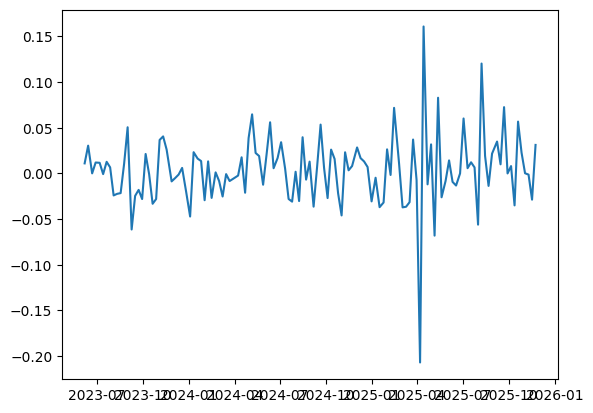

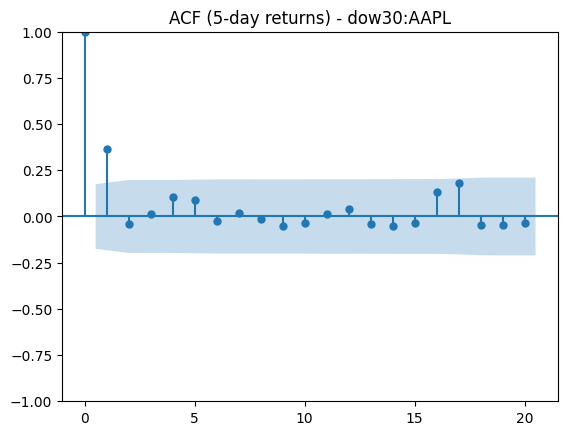

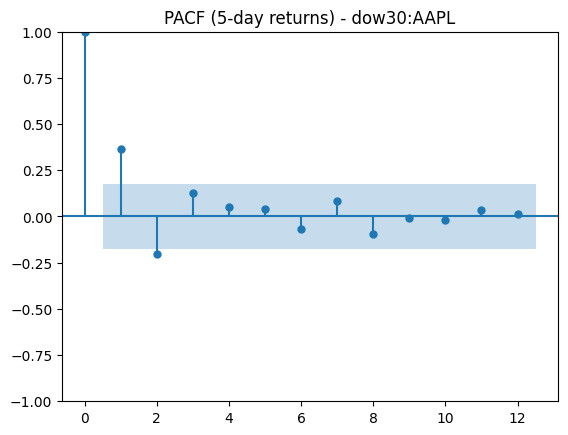

In [250]:
# R['dow30:AAPL']
asset = "dow30:AAPL"   # change
s = R[asset].dropna()

# s = s[80:]
# s = s.sort_index(ascending=False)
plt.plot(s)
print(s)
fig = plot_acf(s**2, lags=20 )
plt.title(f"ACF (5-day returns) - {asset}")
plt.show()

fig = plot_pacf(s**2, lags=12, method="ywm")
plt.title(f"PACF (5-day returns) - {asset}")
plt.show()

In [251]:
# ## ACF PACF for daily returns
# asset = "dow30:AAPL"  # change
# daily_ret = np.log(close_df[asset] / close_df[asset].shift(1)).dropna()
# print(daily_ret.shape)
# daily_ret = daily_ret[780:-20]
# plot_acf(daily_ret, lags=20)
# plt.title(f"ACF (daily returns) - {asset}")
# plt.show()

# plot_pacf(daily_ret, lags=30, method="ywm")
# plt.title(f"PACF (daily returns) - {asset}")
# plt.show()

In [252]:
def walk_forward_arma(R, train_len=100, p=1, q=1):
    """
    R: DataFrame (T windows x N assets) of realized period returns
    Returns:
      preds_df: DataFrame same shape as R for t>=train_len (NaN before)
    """
    T, N = R.shape
    preds = pd.DataFrame(index=R.index, columns=R.columns, dtype=float)

    for t in range(train_len, T):
        hist = R.iloc[t-train_len:t]  # past train_len windows
        for a in R.columns:
            preds.loc[R.index[t], a] = arma_forecast_one(hist[a].values, p=p, q=q)

    return preds

In [253]:
def walk_forward_sample_mean(R, train_len=100):
    preds = pd.DataFrame(index=R.index, columns=R.columns, dtype=float)
    for t in range(train_len, len(R)):
        preds.iloc[t] = R.iloc[t-train_len:t].mean(axis=0)
    return preds

In [254]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def pooled_metrics(y_true, y_pred):
    m = np.isfinite(y_true) & np.isfinite(y_pred)
    yt, yp = y_true[m], y_pred[m]
    print(yt.shape)
    return {
        "MSE": mean_squared_error(yt, yp),
        "MAE": mean_absolute_error(yt, yp),
        "R2": r2_score(yt, yp),
        "SignAcc": float((np.sign(yt) == np.sign(yp)).mean()),
        "Corr": float(np.corrcoef(yt, yp)[0, 1]) if len(yt) > 1 else np.nan,
    }


In [255]:
### COMPARE ARMA(1,1) & S Mean

# arma_preds = walk_forward_arma(R, train_len=100, p=1, q=1)
# mean_preds = walk_forward_sample_mean(R, train_len=100)

# # evaluate only where predictions exist
# mask = arma_preds.notna().values
# y_true = R.values[mask]
# y_arma = arma_preds.values[mask]
# y_mean = mean_preds.values[mask]

# print("ARMA:", pooled_metrics(y_true, y_arma))
# print("Mean:", pooled_metrics(y_true, y_mean))

# arma_preds.tail(27)

In [256]:
##Grid Search ARMA
def arma_grid_search(
    R,
    train_len=100,
    p_grid=(0, 1, 2),
    q_grid=(0, 1, 2),
    metric="MAE",          # choose "MAE" or "MSE" or "R2"
    verbose=True,
):
    rows = []

    for p in p_grid:
        for q in q_grid:
            # skip the degenerate (0,0) if you want (it becomes just a constant mean-ish model)
            # if p == 0 and q == 0:
            #     continue

            try:
                preds = walk_forward_arma(R, train_len=train_len, p=p, q=q)
            except Exception as e:
                if verbose:
                    print(f"(p,q)=({p},{q}) failed at walk_forward_arma: {e}")
                continue

            mask = preds.notna().values
            if mask.sum() == 0:
                if verbose:
                    print(f"(p,q)=({p},{q}) produced no predictions.")
                continue

            y_true = R.values[mask]
            y_pred = preds.values[mask]

            m = pooled_metrics(y_true, y_pred)
            rows.append({"p": p, "q": q, **m})

            if verbose:
                print(f"(p,q)=({p},{q}) -> {metric}={m[metric]:.6f}, Corr={m['Corr']:.4f}, SignAcc={m['SignAcc']:.4f}")

    res = pd.DataFrame(rows)
    if res.empty:
        return res

    # sort: lower is better for MAE/MSE, higher is better for R2/Corr/SignAcc
    if metric in ("MAE", "MSE"):
        res = res.sort_values(metric, ascending=True)
    else:
        res = res.sort_values(metric, ascending=False)

    return res.reset_index(drop=True)

In [257]:
res = arma_grid_search(
    R,
    train_len=100,
    p_grid=(0,1,2,3),
    q_grid=(0,1,2,3),
    metric="MAE",
    verbose=True
)

print(res.head(10))

/Users/burakkara/OZU/CS540/projectCS540/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/burakkara/OZU/CS540/projectCS540/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/burakkara/OZU/CS540/projectCS540/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/burakkara/OZU/CS540/projectCS540/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likeliho

(750,)


/Users/burakkara/OZU/CS540/projectCS540/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/burakkara/OZU/CS540/projectCS540/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/burakkara/OZU/CS540/projectCS540/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/burakkara/OZU/CS540/projectCS540/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likeliho

(750,)


/Users/burakkara/OZU/CS540/projectCS540/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/burakkara/OZU/CS540/projectCS540/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/burakkara/OZU/CS540/projectCS540/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/burakkara/OZU/CS540/projectCS540/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likeliho

(750,)


/Users/burakkara/OZU/CS540/projectCS540/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/burakkara/OZU/CS540/projectCS540/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/burakkara/OZU/CS540/projectCS540/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/burakkara/OZU/CS540/projectCS540/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likeliho

(750,)


/Users/burakkara/OZU/CS540/projectCS540/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/burakkara/OZU/CS540/projectCS540/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/burakkara/OZU/CS540/projectCS540/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/burakkara/OZU/CS540/projectCS540/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likeliho

(750,)


/Users/burakkara/OZU/CS540/projectCS540/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/burakkara/OZU/CS540/projectCS540/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/burakkara/OZU/CS540/projectCS540/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/burakkara/OZU/CS540/projectCS540/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likeliho

(750,)


/Users/burakkara/OZU/CS540/projectCS540/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/burakkara/OZU/CS540/projectCS540/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/burakkara/OZU/CS540/projectCS540/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/burakkara/OZU/CS540/projectCS540/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likeliho

(750,)


/Users/burakkara/OZU/CS540/projectCS540/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/burakkara/OZU/CS540/projectCS540/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/burakkara/OZU/CS540/projectCS540/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/burakkara/OZU/CS540/projectCS540/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likeliho

(750,)


/Users/burakkara/OZU/CS540/projectCS540/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/burakkara/OZU/CS540/projectCS540/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/burakkara/OZU/CS540/projectCS540/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/burakkara/OZU/CS540/projectCS540/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likeliho

(750,)


/Users/burakkara/OZU/CS540/projectCS540/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/burakkara/OZU/CS540/projectCS540/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/burakkara/OZU/CS540/projectCS540/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/burakkara/OZU/CS540/projectCS540/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likeliho

(750,)


/Users/burakkara/OZU/CS540/projectCS540/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/burakkara/OZU/CS540/projectCS540/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/burakkara/OZU/CS540/projectCS540/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/burakkara/OZU/CS540/projectCS540/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likeliho

(750,)


/Users/burakkara/OZU/CS540/projectCS540/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/burakkara/OZU/CS540/projectCS540/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/burakkara/OZU/CS540/projectCS540/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/burakkara/OZU/CS540/projectCS540/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likeliho

(750,)


/Users/burakkara/OZU/CS540/projectCS540/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/burakkara/OZU/CS540/projectCS540/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/burakkara/OZU/CS540/projectCS540/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/burakkara/OZU/CS540/projectCS540/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likeliho

(750,)


/Users/burakkara/OZU/CS540/projectCS540/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/burakkara/OZU/CS540/projectCS540/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/burakkara/OZU/CS540/projectCS540/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/burakkara/OZU/CS540/projectCS540/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likeliho

(750,)


/Users/burakkara/OZU/CS540/projectCS540/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/burakkara/OZU/CS540/projectCS540/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/burakkara/OZU/CS540/projectCS540/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/burakkara/OZU/CS540/projectCS540/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likeliho

(750,)


/Users/burakkara/OZU/CS540/projectCS540/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/burakkara/OZU/CS540/projectCS540/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/burakkara/OZU/CS540/projectCS540/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/burakkara/OZU/CS540/projectCS540/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likeliho

(750,)
   p  q       MSE       MAE        R2   SignAcc      Corr
0  0  0  0.001190  0.024646 -0.002833  0.038667  0.075153
1  1  0  0.001211  0.024850 -0.020724  0.508000  0.002163
2  0  1  0.001225  0.024955 -0.031956  0.486667 -0.033230
3  1  1  0.001225  0.025149 -0.031946  0.493333  0.002350
4  2  0  0.001232  0.025171 -0.038427  0.473333 -0.024979
5  0  2  0.001238  0.025185 -0.042969  0.485333 -0.014030
6  0  3  0.001237  0.025359 -0.042688  0.464000  0.041910
7  1  2  0.001245  0.025383 -0.049188  0.488000 -0.008119
8  3  0  0.001225  0.025461 -0.032523  0.462667  0.073715
9  1  3  0.001237  0.025542 -0.042116  0.476000  0.059289


In [258]:
# best = res.iloc[0]
# p_best, q_best = int(best["p"]), int(best["q"])

# arma_best = walk_forward_arma(R, train_len=100, p=p_best, q=q_best)
# mean_preds = walk_forward_sample_mean(R, train_len=100)

# mask = arma_best.notna().values
# y_true = R.values[mask]
# y_arma = arma_best.values[mask]
# y_mean = mean_preds.values[mask]

# print("Best ARMA:", (p_best, q_best), pooled_metrics(y_true, y_arma))
# print("Mean:", pooled_metrics(y_true, y_mean))